In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time



In [2]:
dfi = pd.read_csv('./Data/Stock/^N100.csv',parse_dates=True,index_col='Datetime')
dfi

,Close,High,Low,Open
Datetime,,,,
2022-10-31 08:00:00+00:00,1190.329956,1195.300049,1188.359985,1192.170044
2022-10-31 09:00:00+00:00,1191.829956,1193.239990,1189.839966,1190.439941
2022-10-31 10:00:00+00:00,1192.339966,1192.750000,1191.119995,1191.949951
2022-10-31 11:00:00+00:00,1191.219971,1193.630005,1190.520020,1192.359985
2022-10-31 12:00:00+00:00,1191.569946,1191.890015,1190.219971,1191.189941
...,...,...,...,...
2024-10-28 12:00:00+00:00,1476.699951,1477.020020,1471.530029,1473.359985
2024-10-28 13:00:00+00:00,1476.359985,1477.949951,1475.449951,1476.719971
2024-10-28 14:00:00+00:00,1480.760010,1481.479980,1474.949951,1476.380005


In [3]:
# df = dfi.loc[dfi['pickup_datetime'] > '2016-08-01']
# df

In [4]:
df = dfi[['Open','High','Low','Close']]
df = df.dropna()
#df = df.reset_index(drop=True)
df

,Open,High,Low,Close
Datetime,,,,
2022-10-31 08:00:00+00:00,1192.170044,1195.300049,1188.359985,1190.329956
2022-10-31 09:00:00+00:00,1190.439941,1193.239990,1189.839966,1191.829956
2022-10-31 10:00:00+00:00,1191.949951,1192.750000,1191.119995,1192.339966
2022-10-31 11:00:00+00:00,1192.359985,1193.630005,1190.520020,1191.219971
2022-10-31 12:00:00+00:00,1191.189941,1191.890015,1190.219971,1191.569946
...,...,...,...,...
2024-10-28 12:00:00+00:00,1473.359985,1477.020020,1471.530029,1476.699951
2024-10-28 13:00:00+00:00,1476.719971,1477.949951,1475.449951,1476.359985
2024-10-28 14:00:00+00:00,1476.380005,1481.479980,1474.949951,1480.760010


In [5]:
df['nxt_target'] = df['Close'].shift(-1)
df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]

/tmp/ipykernel_103017/2437957435.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]
/tmp/ipykernel_103017/2437957435.py:2: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4599 entries, 2022-10-31 08:00:00+00:00 to 2024-10-28 16:00:00+00:00
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        4599 non-null   float64
 1   High        4599 non-null   float64
 2   Low         4599 non-null   float64
 3   Close       4599 non-null   float64
 4   nxt_target  4599 non-null   float64
dtypes: float64(5)
memory usage: 215.6 KB


In [7]:
size = int(len(df) * 0.8)

train = df.iloc[:size].copy()
test = df.iloc[size:].copy()
train

,Open,High,Low,Close,nxt_target
Datetime,,,,,
2022-10-31 08:00:00+00:00,1192.170044,1195.300049,1188.359985,1190.329956,1191.829956
2022-10-31 09:00:00+00:00,1190.439941,1193.239990,1189.839966,1191.829956,1192.339966
2022-10-31 10:00:00+00:00,1191.949951,1192.750000,1191.119995,1192.339966,1191.219971
2022-10-31 11:00:00+00:00,1192.359985,1193.630005,1190.520020,1191.219971,1191.569946
2022-10-31 12:00:00+00:00,1191.189941,1191.890015,1190.219971,1191.569946,1193.630005
...,...,...,...,...,...
2024-06-06 09:00:00+00:00,1544.359985,1545.609985,1543.839966,1545.310059,1546.920044
2024-06-06 10:00:00+00:00,1545.390015,1546.949951,1544.719971,1546.920044,1547.290039
2024-06-06 11:00:00+00:00,1546.930054,1547.949951,1546.660034,1547.290039,1544.359985


In [8]:
train.iloc[:,-1:]

,nxt_target
Datetime,
2022-10-31 08:00:00+00:00,1191.829956
2022-10-31 09:00:00+00:00,1192.339966
2022-10-31 10:00:00+00:00,1191.219971
2022-10-31 11:00:00+00:00,1191.569946
2022-10-31 12:00:00+00:00,1193.630005
...,...
2024-06-06 09:00:00+00:00,1546.920044
2024-06-06 10:00:00+00:00,1547.290039
2024-06-06 11:00:00+00:00,1544.359985


In [9]:
train.iloc[:,:4]

,Open,High,Low,Close
Datetime,,,,
2022-10-31 08:00:00+00:00,1192.170044,1195.300049,1188.359985,1190.329956
2022-10-31 09:00:00+00:00,1190.439941,1193.239990,1189.839966,1191.829956
2022-10-31 10:00:00+00:00,1191.949951,1192.750000,1191.119995,1192.339966
2022-10-31 11:00:00+00:00,1192.359985,1193.630005,1190.520020,1191.219971
2022-10-31 12:00:00+00:00,1191.189941,1191.890015,1190.219971,1191.569946
...,...,...,...,...
2024-06-06 09:00:00+00:00,1544.359985,1545.609985,1543.839966,1545.310059
2024-06-06 10:00:00+00:00,1545.390015,1546.949951,1544.719971,1546.920044
2024-06-06 11:00:00+00:00,1546.930054,1547.949951,1546.660034,1547.290039


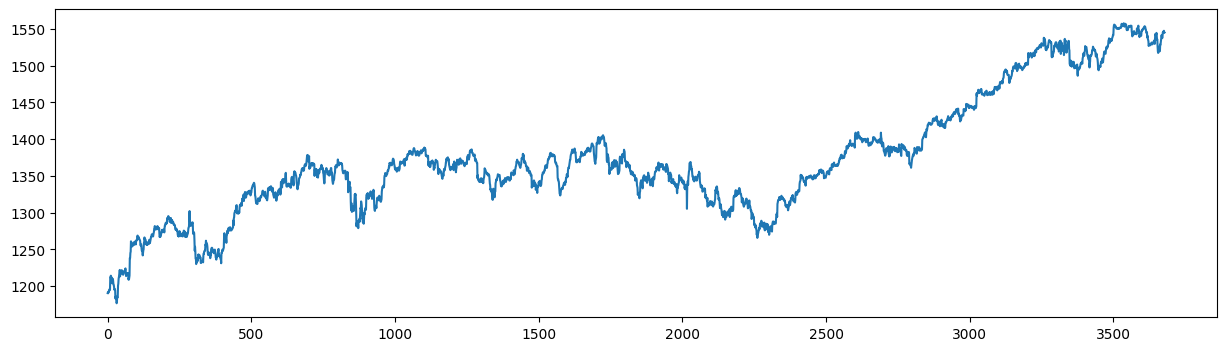

In [10]:
%matplotlib inline
plt.figure(figsize=(15, 4))
plt.plot(range(len(train)), train["Close"])
plt.show()

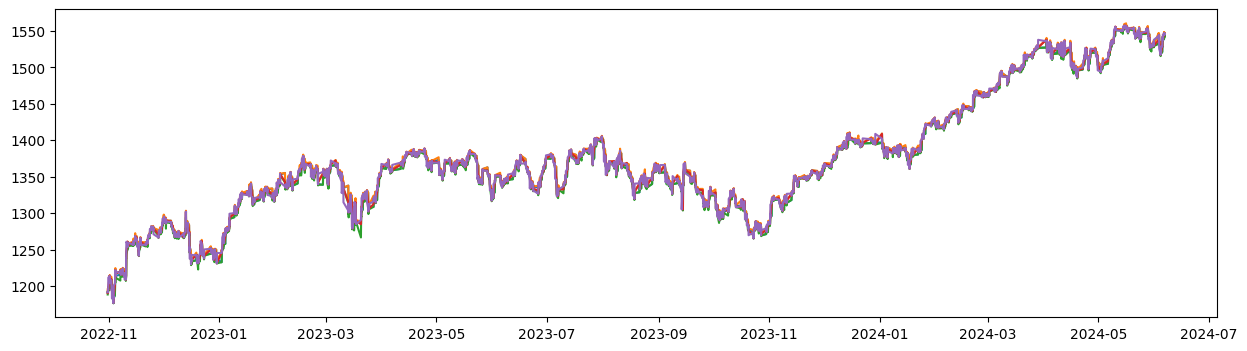

In [11]:
plt.figure(figsize=(15, 4))
plt.plot(train)
plt.show()

In [12]:
def data_process(data, window_size, predict_size):
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    d_y = scaler1.fit_transform(data.iloc[:,-1:])
    data = scaler2.fit_transform(data.iloc[:,:4])

    data_in = []
    data_out = []
    # range(window_size,len(data)-predict_size+1) range(data.shape[0] - window_size - predict_size + 1)
    for i in range(window_size,len(data)-predict_size+1):
        data_in.append(data[i-window_size:i,0:data.shape[0]])
        data_out.append(d_y[i + predict_size - 1:i + predict_size,0])

    data_in = np.array(data_in)
    data_out = np.array(data_out)

    data_process = {'datain': data_in, 'dataout': data_out}

    return data_process, scaler1 , scaler2

In [13]:
from numpy.random import default_rng
from qiskit_algorithms.utils import algorithm_globals
qubits = 4
seed = 42
np.random.seed(seed)
torch.manual_seed(42)
rng = default_rng(seed)
algorithm_globals.random_seed = seed
features_size = 4
#window_size = features_size * 3
window_size = 10
predict_size = 1

In [14]:
train_processed, train_target_scalar, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_target_scalar, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [15]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [16]:
print(X_train.shape)
X_train[0][0]

torch.Size([3669, 10, 4])


tensor([-2.2217, -2.2125, -2.2372, -2.2455])

In [17]:
class ShallowRegressionGRU(nn.Module):
    def __init__(self, num_sensors, hidden_units, num_layers = 1):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = num_layers

        self.gru = nn.GRU(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
         # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_units,device=x.device).requires_grad_()

        # Forward propagate LSTM
        out, _ = self.gru(x, h0.detach())
        #print(out.size())
        out = out[:, -1, :]
        #print(out.size())
        out = out.reshape(out.shape[0], -1)
       #print(out.size())
        # Decode the hidden state of the last time step
        out = self.linear(out)
        return out

In [18]:
batch_size = 4
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = ShallowRegressionGRU(num_sensors=4, hidden_units= 6, num_layers=2)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

In [19]:
modelQ

ShallowRegressionGRU(
  (gru): GRU(4, 6, num_layers=2, batch_first=True)
  (linear): Linear(in_features=6, out_features=1, bias=True)
)

In [20]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)

count = 0
for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        output = modelQ(x)

        label = y.squeeze(1)
        #print(output)
        #print(label)
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)
    
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)} ')

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1/5]  LossQ:49.85974662373883 
[2/5]  LossQ:6.257771885233524 
[3/5]  LossQ:9.808371240030056 
[4/5]  LossQ:14.674870521732373 
[5/5]  LossQ:19.391868234453796 


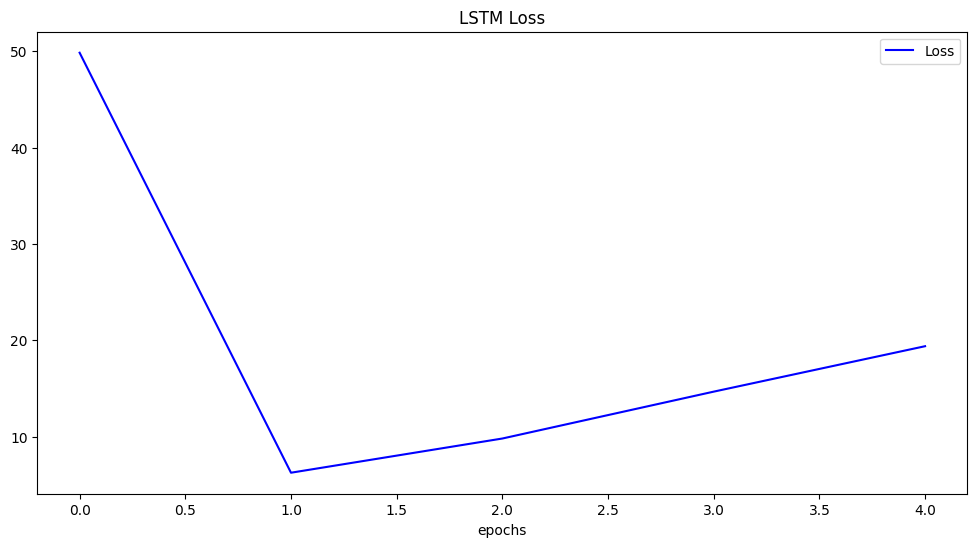

In [21]:
np.savetxt('./SavedModels/Stock/N100/loss/stacked_cgru.txt',histQ)
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('LSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [22]:
pred_y_train = modelQ(X_train)
pred_y_test = modelQ(X_test)

print(pred_y_train)

tensor([[-0.3348],
        [-0.3294],
        [-0.3270],
        ...,
        [ 2.1380],
        [ 2.1353],
        [ 2.1275]], grad_fn=<AddmmBackward0>)


In [23]:
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)


In [24]:
pred_y_train

tensor([[-0.3348],
        [-0.3294],
        [-0.3270],
        ...,
        [ 2.1380],
        [ 2.1353],
        [ 2.1275]], grad_fn=<ViewBackward0>)

In [25]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

In [26]:
np.savetxt('./SavedModels/Stock/N100/train/stacked_cgru.txt',y_train_pred)
np.savetxt('./SavedModels/Stock/N100/test/stacked_cgru.txt',y_test_pred)

Training dataset RMSE:71.57985915306483


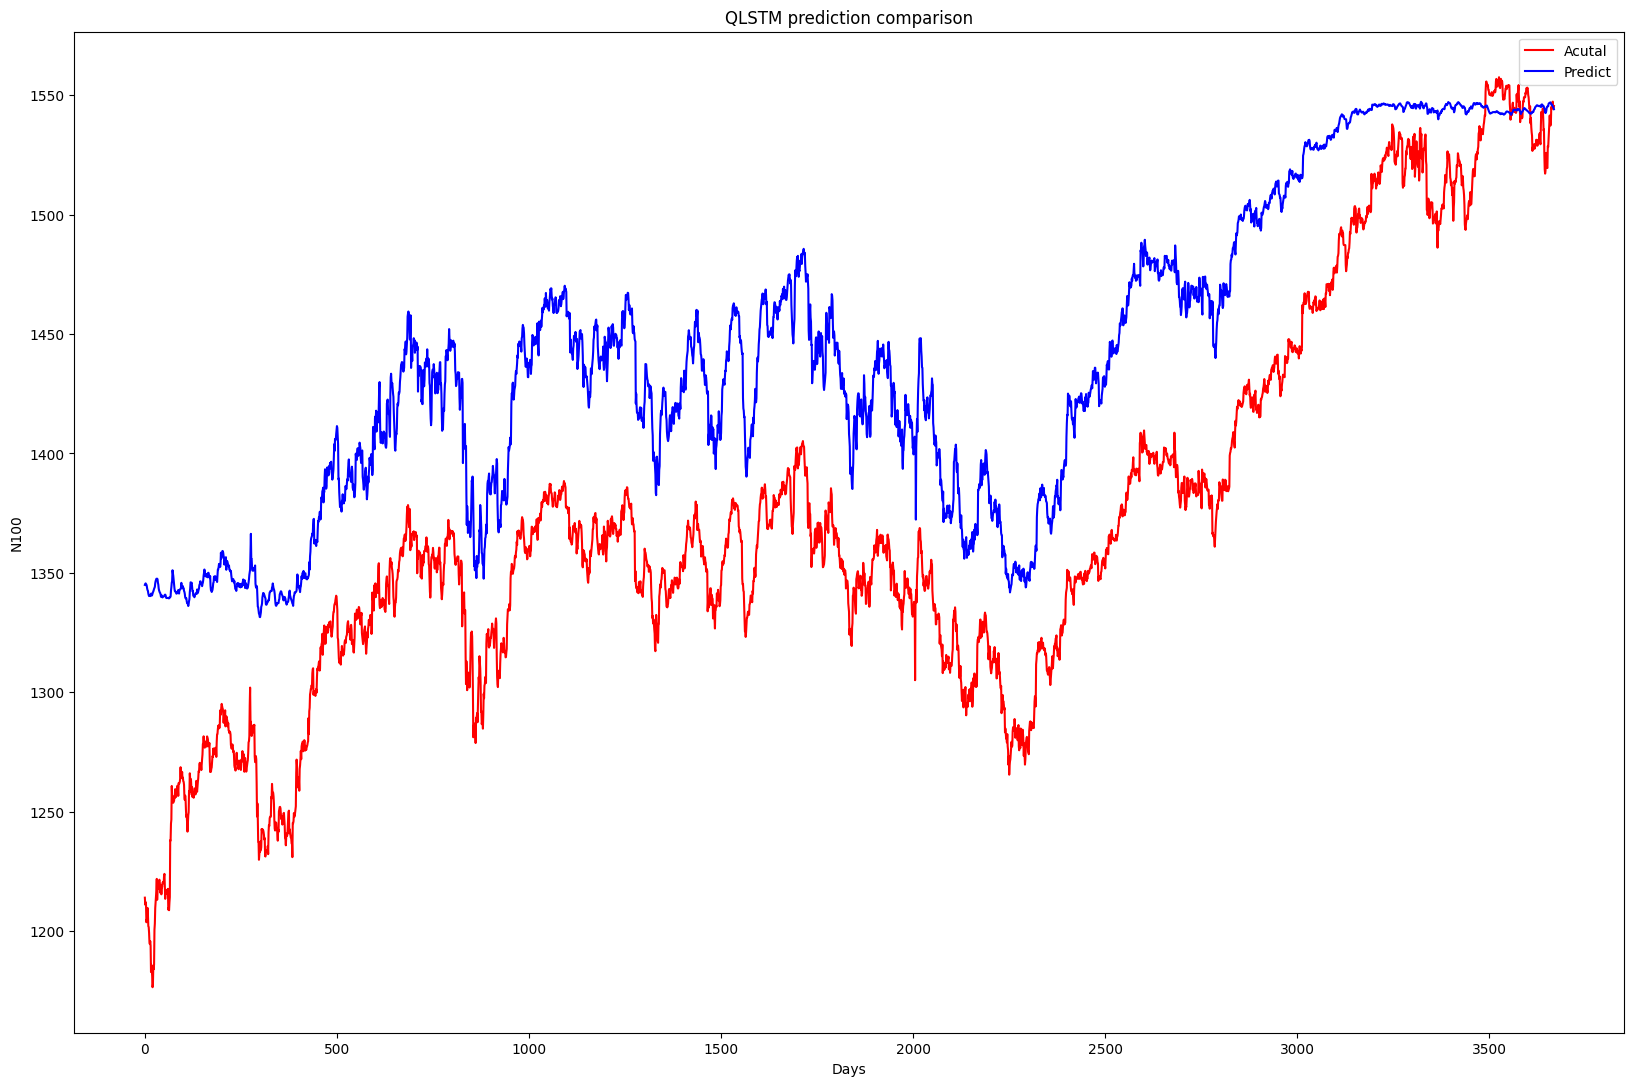

In [27]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('N100')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:28.402020204476027


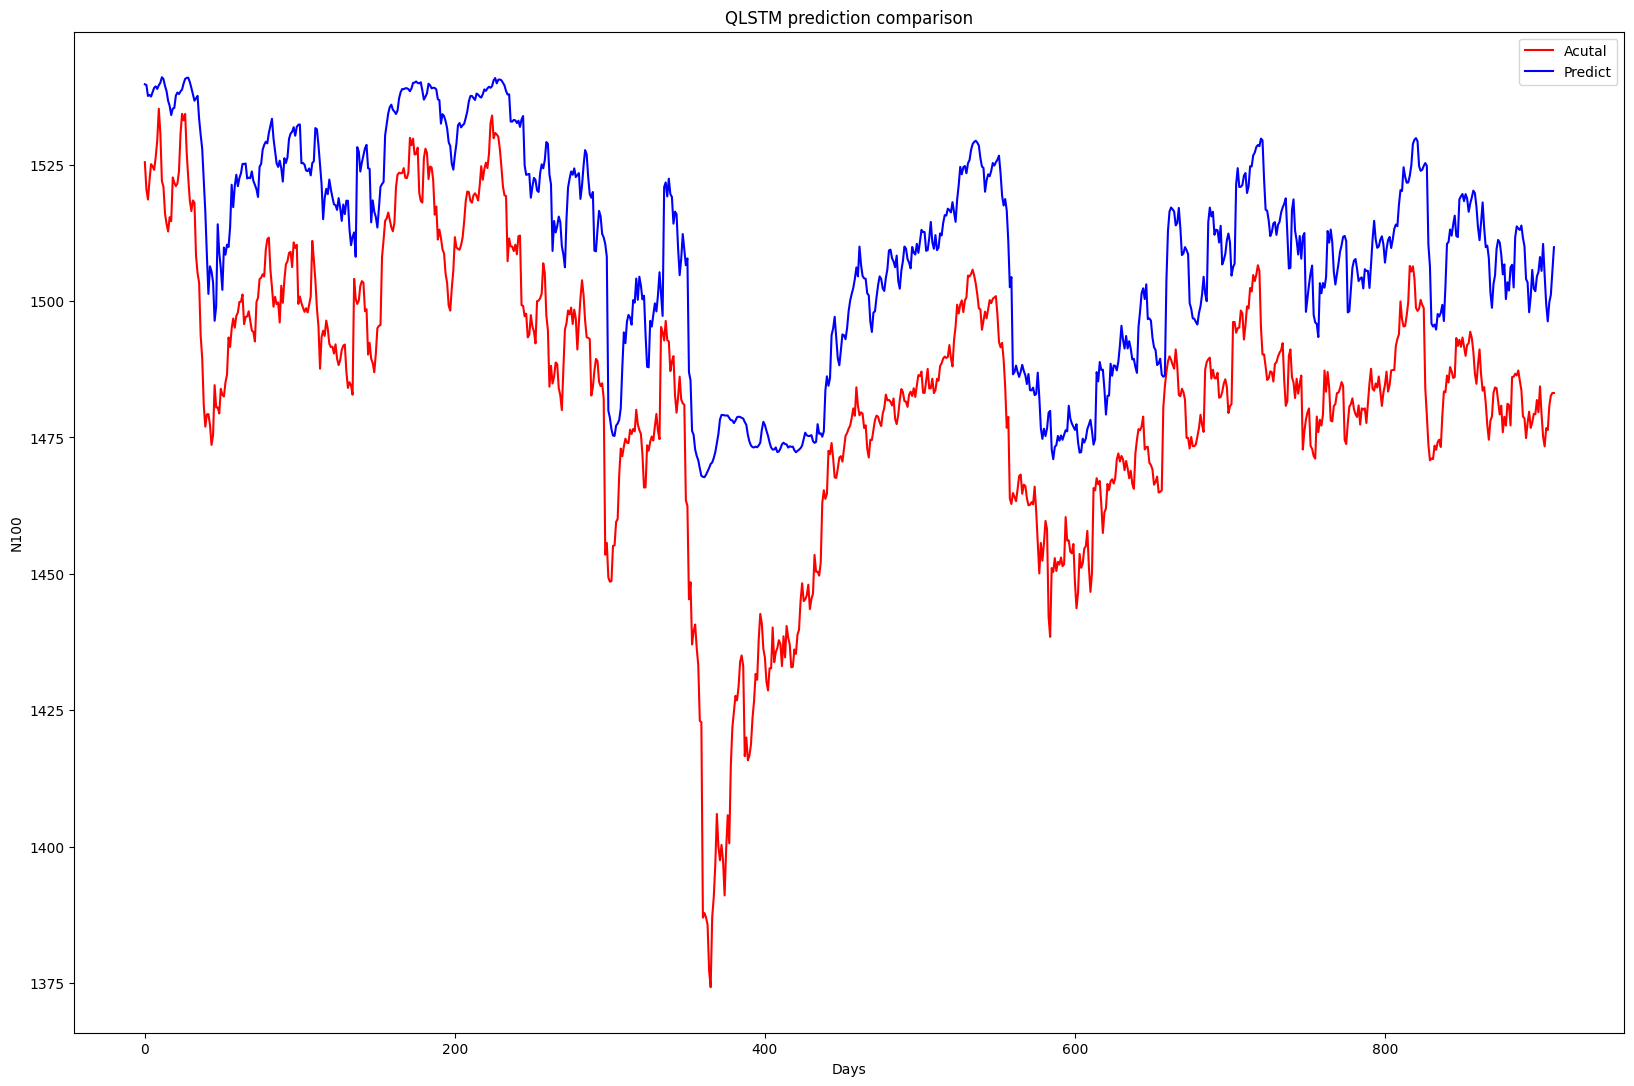

In [28]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('N100')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

In [29]:
torch.save(modelQ,'./SavedModels/Stock/N100/model/stacked_CGRU')